In [8]:
import os
import sys

import tensorflow as tf
import numpy as np
import pandas as pd
import keras
from keras.backend.tensorflow_backend import set_session

import matplotlib.pyplot as plt

import nibabel as nib

In [9]:
def plot(img):
    plt.figure()
    plt.imshow(img[:, 40, :], cmap='gray')
    
def load_nii(path):
    nii = nib.load(path)
    vol = nii.get_data().astype(np.float32)
    return np.squeeze(vol)

In [10]:
# generator config, run_dir, etc...
run_dir = '../runs/gan_20190415_1939_gpu=2_bs=4_enc=[16_32_64_128]_dec=[128_64_32_32_16_8]_cbn=16_lr=0.0001_b1=0.0_b2=0.9_ep=0.1_pl=25.0_vr=1.0_ti=True_is=5_cs=5_rf=10_rs=25_glw=[100_10_100_1]_clw=[1_1_10]_tag=brains_deeper_gen/'
pre_dir = os.path.join(run_dir, 'test', 'gen_150')

csv_path = os.path.join(pre_dir, 'meta.csv')
csv = pd.read_csv(csv_path)
print(csv.shape)

(271, 38)


In [11]:
# regresser
run_dir = '../../../../backup/agemorph/models/reg/reg_20190325_0019_gpu=1_bs=8_lr=0.0001_b1=0.9_b2=0.999_ep=0.1_bn=True_ds=2_lw=[1.0]/'
model_name = 'reg_200.h5'
model_file = os.path.join(run_dir, model_name)

if os.path.isfile(model_file):
    print('found model file')

found model file


In [12]:
# gpu config
gpu_id = 7

if gpu_id is not None:                                                     
    gpu = '/gpu:' + str(gpu_id)                                            
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)                       
    config = tf.ConfigProto()                                              
    config.gpu_options.allow_growth = True                                 
    config.allow_soft_placement = True                                     
    set_session(tf.Session(config=config))                                 
else:                                                                      
    gpu = '/cpu:0'

In [14]:
print('starting predict')

with tf.device(gpu):
    
    # load classifier model
    regressor = keras.models.load_model(model_file)
    
    for i, (_, row) in enumerate(csv.iterrows()):
        
        if i % 10 == 0:
            print('step', i)
        
        xr = load_nii(row['img_path_0'])[None, ..., None]
        yr = load_nii(row['img_path_1'])[None, ..., None]
        yf = load_nii(row['img_path_yf'])[None, ..., None]
        
        batch = np.concatenate([xr, yr, yf], axis=0)
        
        pred = regressor.predict([batch])
        
        csv.loc[csv.img_id_0 == row['img_id_0'], 'age_xr'] = pred[0]
        csv.loc[csv.img_id_0 == row['img_id_0'], 'age_yr'] = pred[1]
        csv.loc[csv.img_id_0 == row['img_id_0'], 'age_yf'] = pred[2]
        
    print('done')

starting predict
step 0
step 10
step 20
step 30
step 40
step 50
step 60
step 70
step 80
step 90
step 100
step 110
step 120
step 130
step 140
step 150
step 160
step 170
step 180
step 190
step 200
step 210
step 220
step 230
step 240
step 250
step 260
step 270
done


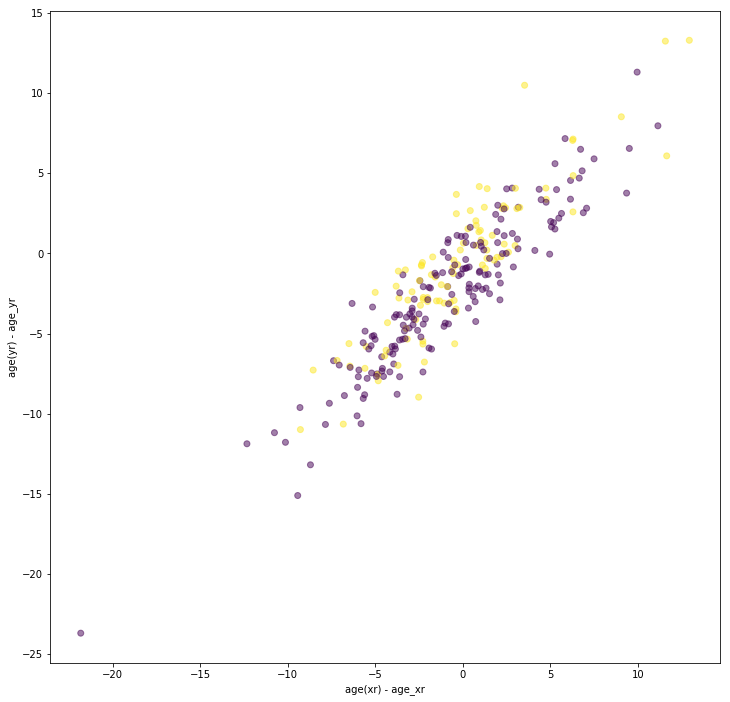

In [18]:
x = csv.age_xr - csv.pat_age_0
y = csv.age_yr - csv.pat_age_1
c = csv.pat_dx_1

plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=c, alpha=0.5)
plt.xlabel('age(xr) - age_xr')
plt.ylabel('age(yr) - age_yr')
plt.show()